# Search-7-CSP-Consistency

**Navigation** : [<< Search-6 CSP-Fundamentals](Search-6-CSP-Fundamentals.ipynb) | [Index](../README.md) | [Search-8 CSP-Advanced >>](Search-8-CSP-Advanced.ipynb)

## Propagation de Contraintes et Consistance

Ce notebook explore les techniques de **propagation de contraintes** qui permettent de reduire l'espace de recherche avant et pendant la resolution d'un CSP. Au lieu de simplement verifier les contraintes apres chaque assignation (backtracking), ces techniques **eliminent proactivement** les valeurs impossibles des domaines.

### Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Distinguer** les niveaux de consistance : noeud, arc, chemin
2. **Implementer** l'algorithme AC-3 pour la consistance d'arc
3. **Integrer** le Forward Checking avec le backtracking
4. **Combiner** AC-3 et backtracking dans l'algorithme MAC
5. **Comparer** experimentalement Backtracking, FC et MAC

### Prerequis
- Search-6 : formalisme CSP, backtracking, heuristiques MRV/LCV
- Bases de Python : recursion, dictionnaires, files (deque)

### Duree estimee : 45 minutes

### Lien avec d'autres series

Voir les notebooks App-6 (Minesweeper) et App-7 (Wordle) pour des applications utilisant la consistance d'arc.

---

## 1. Pourquoi la propagation de contraintes ? (~5 min)

Dans le notebook precedent (Search-6), nous avons vu que le backtracking detecte les conflits au moment de l'assignation. Cependant, il ne tire pas pleinement parti de la structure des contraintes : il attend de tenter une assignation pour decouvrir un conflit.

**Idee cle** : au lieu d'attendre passivement, on peut **propager les consequences** de chaque assignation pour eliminer des valeurs impossibles dans les domaines des autres variables. C'est la **propagation de contraintes**.

### Le compromis fondamental

| Approche | Cout de propagation | Reduction de l'espace | Quand l'utiliser |
|----------|--------------------|-----------------------|------------------|
| Backtracking pur | Aucun | Minimale | Petits problemes |
| Forward Checking | Faible | Moderee | Problemes moyens |
| AC-3 seul | Modere | Forte | Pre-traitement |
| MAC (AC-3 + BT) | Eleve | Maximale | Problemes difficiles |

### Niveaux de consistance

La consistance peut etre assuree a differents niveaux, du plus simple au plus fort :

$$\text{Node Consistency} \subset \text{Arc Consistency} \subset \text{Path Consistency} \subset \text{k-Consistency}$$

Plus le niveau est fort, plus l'elagage est important, mais plus le cout de propagation est eleve.

In [1]:
# Imports pour tout le notebook
import sys
import copy
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from collections import deque

# Helpers partages de la serie Search
sys.path.insert(0, '..')
from search_helpers import draw_csp_graph, benchmark_table, plot_benchmark

%matplotlib inline

print("Imports OK")

Imports OK


### Classe CSP (rappel de Search-6)

Nous reutilisons la classe CSP definie dans le notebook precedent, avec quelques methodes supplementaires pour la propagation.

In [2]:
class CSP:
    """Probleme de Satisfaction de Contraintes (CSP).

    Represente un CSP binaire avec variables, domaines, voisins
    et une fonction de contrainte.
    """

    def __init__(self, variables, domains, neighbors, constraint_func):
        self.variables = variables
        self.domains = {v: list(d) for v, d in domains.items()}
        self.neighbors = neighbors
        self.constraint_func = constraint_func
        self.n_assigns = 0
        self.n_backtracks = 0

    def consistent(self, var, val, assignment):
        """Verifie si (var=val) est consistant avec l'assignation partielle."""
        for other_var in self.neighbors[var]:
            if other_var in assignment:
                if not self.constraint_func(var, val, other_var, assignment[other_var]):
                    return False
        return True

    def is_complete(self, assignment):
        """Verifie si toutes les variables sont assignees."""
        return len(assignment) == len(self.variables)

    def is_solution(self, assignment):
        """Verifie si l'assignation est une solution (complete et consistante)."""
        if not self.is_complete(assignment):
            return False
        for var in self.variables:
            if not self.consistent(var, assignment[var], assignment):
                return False
        return True

    def reset_counters(self):
        """Reinitialise les compteurs."""
        self.n_assigns = 0
        self.n_backtracks = 0

    def copy_domains(self):
        """Retourne une copie profonde des domaines."""
        return {v: list(d) for v, d in self.domains.items()}

    def get_arcs(self):
        """Retourne la liste de tous les arcs (Xi, Xj) du CSP."""
        arcs = []
        for var in self.variables:
            for neighbor in self.neighbors[var]:
                arcs.append((var, neighbor))
        return arcs

    def get_constraints_list(self):
        """Retourne la liste des paires (var1, var2) de contraintes (sans doublons)."""
        constraints = []
        seen = set()
        for var in self.variables:
            for neighbor in self.neighbors[var]:
                pair = tuple(sorted([var, neighbor]))
                if pair not in seen:
                    seen.add(pair)
                    constraints.append(pair)
        return constraints

print("Classe CSP definie.")

Classe CSP definie.


Definissons egalement les problemes de reference que nous utiliserons tout au long du notebook : la coloration de l'Australie et les N-Reines.

In [3]:
# === Problemes de reference ===

# --- Coloration de l'Australie ---
australia_vars = ['WA', 'NT', 'SA', 'Q', 'NSW', 'V', 'T']
australia_domains = {v: ['Rouge', 'Vert', 'Bleu'] for v in australia_vars}
australia_neighbors = {
    'WA':  ['NT', 'SA'],
    'NT':  ['WA', 'SA', 'Q'],
    'SA':  ['WA', 'NT', 'Q', 'NSW', 'V'],
    'Q':   ['NT', 'SA', 'NSW'],
    'NSW': ['Q', 'SA', 'V'],
    'V':   ['SA', 'NSW'],
    'T':   []
}

def different_values(var1, val1, var2, val2):
    """Contrainte : deux variables voisines doivent avoir des valeurs differentes."""
    return val1 != val2

def make_australia_csp():
    """Cree une nouvelle instance du CSP de coloration de l'Australie."""
    return CSP(australia_vars, australia_domains,
               australia_neighbors, different_values)

# --- N-Reines ---
def make_nqueens_csp(n):
    """Cree un CSP pour le probleme des N-Reines."""
    variables = list(range(n))
    domains = {col: list(range(n)) for col in variables}
    neighbors = {col: [c for c in variables if c != col] for col in variables}

    def queens_constraint(c1, r1, c2, r2):
        if r1 == r2:
            return False
        if abs(c1 - c2) == abs(r1 - r2):
            return False
        return True

    return CSP(variables, domains, neighbors, queens_constraint)

# --- Visualisation N-Reines ---
def draw_queens(solution, n, title="Solution N-Reines"):
    """Visualise la solution du probleme des N-Reines."""
    fig, ax = plt.subplots(figsize=(max(5, n * 0.7), max(5, n * 0.7)))
    for row in range(n):
        for col in range(n):
            color = '#F0D9B5' if (row + col) % 2 == 0 else '#B58863'
            rect = plt.Rectangle((col, n - 1 - row), 1, 1,
                                 facecolor=color, edgecolor='black')
            ax.add_patch(rect)
    if solution:
        for col, row in solution.items():
            ax.text(col + 0.5, n - 1 - row + 0.5, 'Q',
                    ha='center', va='center', fontsize=max(8, 24 - n),
                    fontweight='bold', color='darkred')
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.set_aspect('equal')
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(range(n))
    ax.set_yticklabels(range(n - 1, -1, -1))
    ax.set_xlabel('Colonne')
    ax.set_ylabel('Ligne')
    ax.set_title(title, fontsize=13, fontweight='bold')
    plt.tight_layout()
    return fig

# Heuristique MRV (rappel de Search-6)
def select_mrv(csp, assignment, domains):
    """Heuristique MRV : choisir la variable avec le moins de valeurs viables."""
    unassigned = [v for v in csp.variables if v not in assignment]
    return min(unassigned, key=lambda v: len(domains[v]))

print("Problemes de reference et utilitaires definis.")

Problemes de reference et utilitaires definis.


---

## 2. Node Consistency (~5 min)

La **consistance de noeud** (node consistency) est la forme la plus simple de propagation. Elle ne concerne que les **contraintes unaires** -- celles qui portent sur une seule variable.

### Definition

Une variable $X_i$ est **node-consistent** si et seulement si toutes les valeurs de son domaine $D_i$ satisfont les contraintes unaires portant sur $X_i$.

$$\text{Node-consistent}(X_i) \iff \forall v \in D_i, \text{les contraintes unaires sur } X_i \text{ sont satisfaites pour } v$$

### Exemple

| Variable | Domaine initial | Contrainte unaire | Domaine apres NC |
|----------|----------------|-------------------|------------------|
| $X$ | $\{1, 2, 3, 4, 5\}$ | $X > 2$ | $\{3, 4, 5\}$ |
| $Y$ | $\{a, b, c\}$ | $Y \neq a$ | $\{b, c\}$ |
| $Z$ | $\{1, 2, 3\}$ | (aucune) | $\{1, 2, 3\}$ (inchange) |

In [4]:
def node_consistency(domains, unary_constraints):
    """Applique la consistance de noeud.

    Args:
        domains: dict variable -> liste de valeurs
        unary_constraints: dict variable -> fonction(valeur) -> bool

    Returns:
        domains modifies (en place)
    """
    for var, constraint in unary_constraints.items():
        if var in domains:
            domains[var] = [v for v in domains[var] if constraint(v)]
    return domains


# Exemple : variable X dans {1,2,3,4,5} avec X > 2
example_domains = {
    'X': [1, 2, 3, 4, 5],
    'Y': ['a', 'b', 'c'],
    'Z': [1, 2, 3]
}

unary = {
    'X': lambda v: v > 2,
    'Y': lambda v: v != 'a'
}

print("Avant node consistency :")
for var, dom in example_domains.items():
    print(f"  {var}: {dom}")

node_consistency(example_domains, unary)

print("\nApres node consistency :")
for var, dom in example_domains.items():
    print(f"  {var}: {dom}")

Avant node consistency :
  X: [1, 2, 3, 4, 5]
  Y: ['a', 'b', 'c']
  Z: [1, 2, 3]

Apres node consistency :
  X: [3, 4, 5]
  Y: ['b', 'c']
  Z: [1, 2, 3]


### Interpretation : node consistency

**Sortie obtenue** : les domaines de X et Y sont reduits par les contraintes unaires, Z reste inchange.

| Variable | Avant | Apres | Valeurs eliminees |
|----------|-------|-------|-------------------|
| X | {1,2,3,4,5} | {3,4,5} | 1, 2 (ne satisfont pas X > 2) |
| Y | {a,b,c} | {b,c} | a (ne satisfait pas Y != a) |
| Z | {1,2,3} | {1,2,3} | aucune (pas de contrainte unaire) |

**Points cles** :
1. La consistance de noeud est **triviale** a realiser : un simple filtrage lineaire
2. Elle est toujours appliquee en premier, avant toute autre forme de propagation
3. En pratique, les contraintes unaires sont souvent deja integrees dans les domaines initiaux

> **Limitation** : la consistance de noeud ne regarde pas les relations entre variables. Pour cela, il faut passer a la consistance d'arc.

---

## 3. Arc Consistency et AC-3 (~12 min)

La **consistance d'arc** (arc consistency) est le niveau de propagation le plus utilise en pratique. Elle considere les **contraintes binaires** entre paires de variables.

### Definition

Un arc $(X_i, X_j)$ est **arc-consistent** si pour **chaque** valeur $a \in D_i$, il existe **au moins une** valeur $b \in D_j$ telle que la contrainte entre $X_i$ et $X_j$ est satisfaite.

$$\text{Arc-consistent}(X_i, X_j) \iff \forall a \in D_i, \exists b \in D_j : C(X_i = a, X_j = b)$$

Un CSP est **arc-consistent** si **tous** ses arcs sont arc-consistants.

### Algorithme AC-3

AC-3 (Arc Consistency Algorithm #3) maintient une **file d'arcs a traiter**. Pour chaque arc $(X_i, X_j)$ :
1. Pour chaque valeur $a$ de $D_i$, verifier s'il existe un support dans $D_j$
2. Si une valeur $a$ n'a aucun support, la retirer de $D_i$
3. Si $D_i$ a ete modifie, ajouter a la file tous les arcs $(X_k, X_i)$ pour $k \neq j$

### Complexite

- $e$ = nombre d'arcs, $d$ = taille maximale d'un domaine
- Chaque arc est insere dans la file au plus $d$ fois (un domaine perd au plus $d$ valeurs)
- Pour chaque arc, la verification du support coute $O(d^2)$
- **Complexite totale** : $O(e \cdot d^3)$

Implementons d'abord la fonction `revise` qui traite un arc unique, puis l'algorithme AC-3 complet.

In [5]:
def revise(csp, xi, xj, domains):
    """Rend l'arc (Xi, Xj) arc-consistent.

    Retire de domains[xi] les valeurs qui n'ont aucun support dans domains[xj].

    Returns:
        True si domains[xi] a ete modifie, False sinon.
    """
    revised = False
    to_remove = []

    for val_i in domains[xi]:
        # Chercher un support : au moins une valeur de Xj compatible
        has_support = False
        for val_j in domains[xj]:
            if csp.constraint_func(xi, val_i, xj, val_j):
                has_support = True
                break
        if not has_support:
            to_remove.append(val_i)
            revised = True

    for val in to_remove:
        domains[xi].remove(val)

    return revised


def ac3(csp, domains=None, arcs=None, verbose=False):
    """Algorithme AC-3 : rend le CSP arc-consistent.

    Args:
        csp: le CSP
        domains: domaines courants (modifies en place). Si None, utilise csp.domains.
        arcs: arcs initiaux a traiter. Si None, tous les arcs du CSP.
        verbose: afficher la trace.

    Returns:
        True si le CSP est encore soluble (aucun domaine vide),
        False si un domaine est devenu vide (echec).
    """
    if domains is None:
        domains = csp.domains

    # Initialiser la file avec tous les arcs
    if arcs is None:
        queue = deque(csp.get_arcs())
    else:
        queue = deque(arcs)

    n_revisions = 0

    while queue:
        xi, xj = queue.popleft()

        if revise(csp, xi, xj, domains):
            n_revisions += 1

            if verbose:
                print(f"  REVISE({xi}, {xj}) -> D({xi}) = {domains[xi]}")

            if len(domains[xi]) == 0:
                if verbose:
                    print(f"  ECHEC : domaine de {xi} vide !")
                return False  # Domaine vide : echec

            # Ajouter les arcs (Xk, Xi) pour tous les voisins Xk != Xj
            for xk in csp.neighbors[xi]:
                if xk != xj:
                    queue.append((xk, xi))

    if verbose:
        print(f"  AC-3 termine : {n_revisions} revisions effectuees.")

    return True  # Tous les domaines sont non vides

print("Fonctions revise() et ac3() definies.")

Fonctions revise() et ac3() definies.


### Application : AC-3 sur la coloration de l'Australie

Appliquons AC-3 a la coloration de l'Australie et observons les reductions de domaines. Rappelons que chaque variable commence avec le domaine {Rouge, Vert, Bleu}.

In [6]:
# AC-3 sur la coloration de l'Australie (domaines complets)
csp_aus = make_australia_csp()
domains_aus = csp_aus.copy_domains()

print("Domaines AVANT AC-3 :")
for var in australia_vars:
    print(f"  {var:>3} : {domains_aus[var]}")

print("\nExecution de AC-3 :")
result = ac3(csp_aus, domains_aus, verbose=True)

print(f"\nResultat : {'Consistant' if result else 'Echec'}")
print("\nDomaines APRES AC-3 :")
for var in australia_vars:
    print(f"  {var:>3} : {domains_aus[var]}")

Domaines AVANT AC-3 :
   WA : ['Rouge', 'Vert', 'Bleu']
   NT : ['Rouge', 'Vert', 'Bleu']
   SA : ['Rouge', 'Vert', 'Bleu']
    Q : ['Rouge', 'Vert', 'Bleu']
  NSW : ['Rouge', 'Vert', 'Bleu']
    V : ['Rouge', 'Vert', 'Bleu']
    T : ['Rouge', 'Vert', 'Bleu']

Execution de AC-3 :
  AC-3 termine : 0 revisions effectuees.

Resultat : Consistant

Domaines APRES AC-3 :
   WA : ['Rouge', 'Vert', 'Bleu']
   NT : ['Rouge', 'Vert', 'Bleu']
   SA : ['Rouge', 'Vert', 'Bleu']
    Q : ['Rouge', 'Vert', 'Bleu']
  NSW : ['Rouge', 'Vert', 'Bleu']
    V : ['Rouge', 'Vert', 'Bleu']
    T : ['Rouge', 'Vert', 'Bleu']


### Interpretation : AC-3 sans assignation prealable

**Sortie obtenue** : AC-3 ne reduit aucun domaine sur la coloration australienne sans assignation prealable.

| Variable | Domaine avant | Domaine apres | Reduction |
|----------|--------------|---------------|----------|
| WA, NT, ... | {R, V, B} | {R, V, B} | Aucune |

**Pourquoi ?** Pour chaque valeur de chaque variable, il existe toujours un support dans les voisins (car 3 couleurs pour une contrainte != laisse toujours 2 choix possibles). AC-3 ne peut rien eliminer.

> **Lecon** : AC-3 sur les domaines initiaux n'est pas toujours utile. Sa puissance apparait surtout **apres une assignation**, quand les domaines commencent a se reduire.

### AC-3 apres une assignation

Observons ce qui se passe quand on fixe WA = Rouge, puis qu'on applique AC-3.

In [7]:
# AC-3 apres assignation WA = Rouge
csp_aus2 = make_australia_csp()
domains_aus2 = csp_aus2.copy_domains()

# Simuler l'assignation WA = Rouge en reduisant le domaine
domains_aus2['WA'] = ['Rouge']

print("Domaines apres WA = Rouge :")
for var in australia_vars:
    print(f"  {var:>3} : {domains_aus2[var]}")

print("\nExecution de AC-3 :")
result2 = ac3(csp_aus2, domains_aus2, verbose=True)

print(f"\nResultat : {'Consistant' if result2 else 'Echec'}")
print("\nDomaines APRES AC-3 :")
for var in australia_vars:
    print(f"  {var:>3} : {domains_aus2[var]}")

Domaines apres WA = Rouge :
   WA : ['Rouge']
   NT : ['Rouge', 'Vert', 'Bleu']
   SA : ['Rouge', 'Vert', 'Bleu']
    Q : ['Rouge', 'Vert', 'Bleu']
  NSW : ['Rouge', 'Vert', 'Bleu']
    V : ['Rouge', 'Vert', 'Bleu']
    T : ['Rouge', 'Vert', 'Bleu']

Execution de AC-3 :
  REVISE(NT, WA) -> D(NT) = ['Vert', 'Bleu']
  REVISE(SA, WA) -> D(SA) = ['Vert', 'Bleu']
  AC-3 termine : 2 revisions effectuees.

Resultat : Consistant

Domaines APRES AC-3 :
   WA : ['Rouge']
   NT : ['Vert', 'Bleu']
   SA : ['Vert', 'Bleu']
    Q : ['Rouge', 'Vert', 'Bleu']
  NSW : ['Rouge', 'Vert', 'Bleu']
    V : ['Rouge', 'Vert', 'Bleu']
    T : ['Rouge', 'Vert', 'Bleu']


### Interpretation : AC-3 apres assignation

**Sortie obtenue** : cette fois, AC-3 propage l'assignation WA = Rouge et reduit les domaines des voisins.

| Variable | Domaine avant AC-3 | Domaine apres AC-3 | Explication |
|----------|-------------------|--------------------|--------------|
| WA | {Rouge} | {Rouge} | Fixe par l'assignation |
| NT | {R, V, B} | {V, B} | Voisin de WA : Rouge retire |
| SA | {R, V, B} | {V, B} | Voisin de WA : Rouge retire |
| Q | {R, V, B} | (reduit selon propagation) | Depend de NT et SA |

**Points cles** :
1. L'assignation de WA se propage a ses voisins NT et SA
2. La reduction de NT et SA peut a son tour provoquer des reductions chez leurs voisins (effet de cascade)
3. T (Tasmanie) reste inchangee car elle n'a aucun voisin

> **Observation** : AC-3 apres une assignation fait essentiellement le travail du Forward Checking (section 4) et davantage, car il propage en cascade.

### Visualisation de la propagation

Visualisons l'etat du graphe de contraintes avant et apres l'application de AC-3.

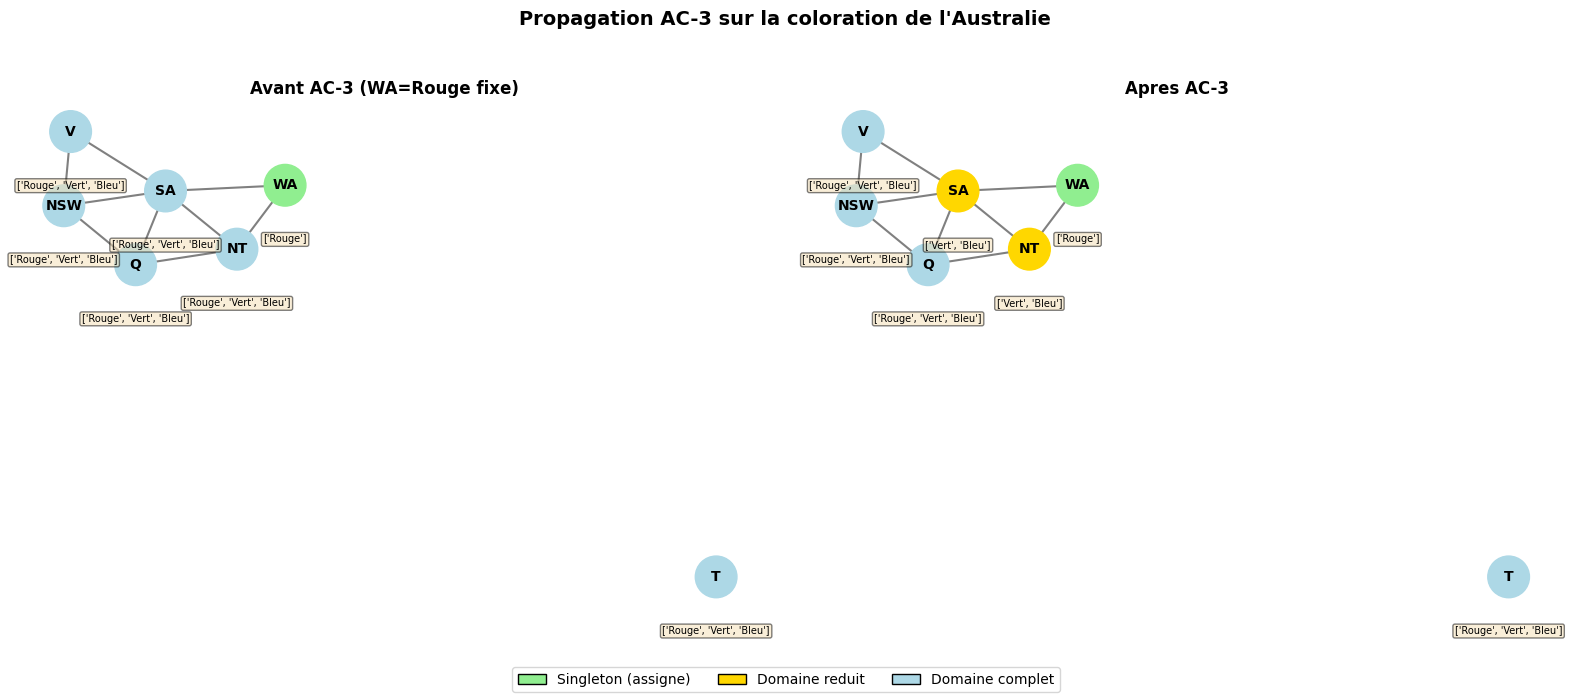

In [8]:
# Visualisation avant et apres AC-3
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

constraints_list = csp_aus2.get_constraints_list()

# Avant AC-3 : domaines initiaux apres assignation WA=Rouge
domains_before = {v: ['Rouge', 'Vert', 'Bleu'] for v in australia_vars}
domains_before['WA'] = ['Rouge']

for ax, doms, title in [
    (axes[0], domains_before, "Avant AC-3 (WA=Rouge fixe)"),
    (axes[1], domains_aus2, "Apres AC-3")
]:
    try:
        import networkx as nx
        G = nx.Graph()
        G.add_nodes_from(australia_vars)
        for c in constraints_list:
            G.add_edge(c[0], c[1])
        pos = nx.spring_layout(G, seed=42)

        colors = []
        for v in G.nodes():
            if len(doms[v]) == 1:
                colors.append('#90EE90')  # Assigne / domaine singleton
            elif len(doms[v]) < 3:
                colors.append('#FFD700')  # Domaine reduit
            else:
                colors.append('#ADD8E6')  # Domaine complet

        nx.draw(G, pos, ax=ax, with_labels=True, node_color=colors,
                node_size=900, font_size=10, font_weight='bold',
                edge_color='gray', width=1.5)

        for v in G.nodes():
            x, y = pos[v]
            dom_str = str(doms[v])
            if len(dom_str) > 25:
                dom_str = f"|D|={len(doms[v])}"
            ax.text(x, y - 0.15, dom_str, ha='center', fontsize=7,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='wheat', alpha=0.5))

        ax.set_title(title, fontsize=12, fontweight='bold')
    except ImportError:
        ax.text(0.5, 0.5, "NetworkX requis", ha='center', va='center')

# Legende
legend_items = [
    mpatches.Patch(facecolor='#90EE90', edgecolor='black', label='Singleton (assigne)'),
    mpatches.Patch(facecolor='#FFD700', edgecolor='black', label='Domaine reduit'),
    mpatches.Patch(facecolor='#ADD8E6', edgecolor='black', label='Domaine complet'),
]
fig.legend(handles=legend_items, loc='lower center', ncol=3, fontsize=10)
plt.suptitle("Propagation AC-3 sur la coloration de l'Australie",
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.06, 1, 0.95])
plt.show()

### Interpretation : visualisation de la propagation

**Sortie obtenue** : la comparaison visuelle montre clairement l'effet de AC-3.

**Points cles** :
1. Les noeuds verts (singleton) representent les variables dont le domaine est reduit a une seule valeur
2. Les noeuds jaunes montrent les variables dont le domaine a ete partiellement reduit
3. La propagation se fait en cascade : l'assignation de WA affecte NT et SA, qui a leur tour affectent Q, NSW et V

> **Resultat important** : dans certains cas, AC-3 seul peut resoudre le CSP completement (quand tous les domaines deviennent des singletons). Sinon, il faut combiner AC-3 avec le backtracking.

### AC-3 peut-il resoudre un CSP seul ?

Testons sur un exemple ou AC-3 suffit a trouver la solution : un petit CSP fortement contraint.

In [9]:
# Exemple ou AC-3 seul resout le CSP
# 3 variables, 2 couleurs, contraintes d'inegalite
# A -- B -- C (chemin lineaire)

small_vars = ['A', 'B', 'C']
small_domains = {'A': ['R', 'V'], 'B': ['R', 'V'], 'C': ['R', 'V']}
small_neighbors = {'A': ['B'], 'B': ['A', 'C'], 'C': ['B']}

csp_small = CSP(small_vars, small_domains, small_neighbors, different_values)

# Fixer A = R
doms_small = csp_small.copy_domains()
doms_small['A'] = ['R']

print("Domaines apres A = R :")
for v in small_vars:
    print(f"  {v}: {doms_small[v]}")

print("\nExecution de AC-3 :")
ac3(csp_small, doms_small, verbose=True)

print("\nDomaines finaux :")
for v in small_vars:
    print(f"  {v}: {doms_small[v]}")

all_singleton = all(len(doms_small[v]) == 1 for v in small_vars)
print(f"\nTous les domaines sont des singletons : {all_singleton}")
if all_singleton:
    solution = {v: doms_small[v][0] for v in small_vars}
    print(f"Solution trouvee par AC-3 seul : {solution}")

Domaines apres A = R :
  A: ['R']
  B: ['R', 'V']
  C: ['R', 'V']

Execution de AC-3 :
  REVISE(B, A) -> D(B) = ['V']
  REVISE(C, B) -> D(C) = ['R']
  AC-3 termine : 2 revisions effectuees.

Domaines finaux :
  A: ['R']
  B: ['V']
  C: ['R']

Tous les domaines sont des singletons : True
Solution trouvee par AC-3 seul : {'A': 'R', 'B': 'V', 'C': 'R'}


### Interpretation : AC-3 comme solveur

**Sortie obtenue** : sur ce petit CSP (chemin lineaire A-B-C, 2 couleurs), AC-3 resout completement le probleme apres la premiere assignation.

| Etape | Action | Domaines |
|-------|--------|----------|
| Initial | A = R | A:{R}, B:{R,V}, C:{R,V} |
| REVISE(B,A) | R retire de B | A:{R}, B:{V}, C:{R,V} |
| REVISE(C,B) | V retire de C | A:{R}, B:{V}, C:{R} |

**Quand AC-3 suffit-il ?** AC-3 seul peut resoudre un CSP quand :
1. Le graphe de contraintes est un **arbre** (pas de cycles)
2. Les domaines sont suffisamment petits par rapport aux contraintes

> **Theoreme** : pour un CSP dont le graphe de contraintes est un arbre, la consistance d'arc garantit la resolution en $O(ed^2)$. Pour les graphes avec cycles, il faut generalement combiner AC-3 avec la recherche.

---

## 4. Forward Checking (~8 min)

Le **Forward Checking** (FC) est une technique qui integre la propagation de contraintes directement dans le backtracking. L'idee est simple :

> Quand on assigne $X_i = v$, on retire immediatement les valeurs incompatibles des domaines des **voisins non assignes** de $X_i$.

### Difference avec le backtracking simple

| Backtracking pur | Forward Checking |
|-------------------|------------------|
| Verifie la consistance seulement avec les variables **deja assignees** | En plus, propage vers les variables **non assignees** |
| Detecte les echecs au moment de l'assignation | Detecte les echecs plus tot (domaine vide) |
| Ne modifie pas les domaines | Reduit les domaines dynamiquement |

### Principe

1. Choisir une variable $X_i$ (avec MRV par exemple)
2. Pour chaque valeur $v \in D_i$ :
   a. Assigner $X_i = v$
   b. Pour chaque voisin non assigne $X_j$, retirer de $D_j$ les valeurs incompatibles avec $v$
   c. Si un domaine devient vide, **backtrack immediatement** (pas besoin d'essayer plus loin)
   d. Sinon, recurser sur les variables restantes
   e. Restaurer les domaines si echec (backtrack)

In [10]:
def forward_checking(csp, var, val, assignment, domains):
    """Propage l'assignation var=val vers les voisins non assignes.

    Retire des domaines des voisins les valeurs incompatibles.

    Returns:
        removals: liste de (variable, valeur) retirees, pour restauration.
        success: True si aucun domaine n'est devenu vide.
    """
    removals = []

    for neighbor in csp.neighbors[var]:
        if neighbor not in assignment:
            for nval in domains[neighbor][:]:
                if not csp.constraint_func(var, val, neighbor, nval):
                    domains[neighbor].remove(nval)
                    removals.append((neighbor, nval))

            if len(domains[neighbor]) == 0:
                return removals, False  # Domaine vide : echec

    return removals, True


def restore_domains(domains, removals):
    """Restaure les valeurs retirees lors du forward checking."""
    for var, val in removals:
        domains[var].append(val)


def backtracking_fc(csp, assignment=None, domains=None, verbose=False):
    """Backtracking avec Forward Checking et heuristique MRV."""
    if assignment is None:
        assignment = {}
        domains = csp.copy_domains()

    if csp.is_complete(assignment):
        return assignment

    var = select_mrv(csp, assignment, domains)

    for val in list(domains[var]):
        csp.n_assigns += 1

        if csp.consistent(var, val, assignment):
            assignment[var] = val

            if verbose:
                indent = "  " * len(assignment)
                print(f"{indent}{var} = {val}")

            # Forward checking : propager vers les voisins
            removals, success = forward_checking(csp, var, val, assignment, domains)

            if success:
                result = backtracking_fc(csp, assignment, domains, verbose)
                if result is not None:
                    return result

            # Restaurer les domaines et desassigner
            restore_domains(domains, removals)
            del assignment[var]
            csp.n_backtracks += 1

    return None

print("Backtracking avec Forward Checking defini.")

Backtracking avec Forward Checking defini.


### Trace du Forward Checking sur la coloration

Observons pas a pas comment le Forward Checking reduit les domaines au fur et a mesure des assignations.

In [11]:
# Trace detaillee du Forward Checking
def fc_trace(csp, verbose=True):
    """Forward Checking avec trace des domaines a chaque etape."""
    assignment = {}
    domains = csp.copy_domains()
    steps = []

    def solve(depth):
        if csp.is_complete(assignment):
            return True

        var = select_mrv(csp, assignment, domains)

        for val in list(domains[var]):
            csp.n_assigns += 1
            if csp.consistent(var, val, assignment):
                assignment[var] = val
                removals, success = forward_checking(csp, var, val, assignment, domains)

                if verbose:
                    indent = "  " * depth
                    status = "OK" if success else "ECHEC (domaine vide)"
                    print(f"{indent}Assigner {var} = {val} [{status}]")
                    if success:
                        # Afficher les domaines restants
                        unassigned = [v for v in csp.variables if v not in assignment]
                        for u in unassigned:
                            print(f"{indent}  D({u}) = {domains[u]}")

                if success:
                    if solve(depth + 1):
                        return True

                restore_domains(domains, removals)
                del assignment[var]

        return False

    found = solve(0)
    return assignment if found else None

# Executer sur la coloration de l'Australie
csp_fc = make_australia_csp()
print("Forward Checking - Coloration de l'Australie")
print("=" * 55)
sol_fc = fc_trace(csp_fc)
print(f"\nSolution : {sol_fc}")
print(f"Assignations : {csp_fc.n_assigns}")

Forward Checking - Coloration de l'Australie
Assigner WA = Rouge [OK]
  D(NT) = ['Vert', 'Bleu']
  D(SA) = ['Vert', 'Bleu']
  D(Q) = ['Rouge', 'Vert', 'Bleu']
  D(NSW) = ['Rouge', 'Vert', 'Bleu']
  D(V) = ['Rouge', 'Vert', 'Bleu']
  D(T) = ['Rouge', 'Vert', 'Bleu']
  Assigner NT = Vert [OK]
    D(SA) = ['Bleu']
    D(Q) = ['Rouge', 'Bleu']
    D(NSW) = ['Rouge', 'Vert', 'Bleu']
    D(V) = ['Rouge', 'Vert', 'Bleu']
    D(T) = ['Rouge', 'Vert', 'Bleu']
    Assigner SA = Bleu [OK]
      D(Q) = ['Rouge']
      D(NSW) = ['Rouge', 'Vert']
      D(V) = ['Rouge', 'Vert']
      D(T) = ['Rouge', 'Vert', 'Bleu']
      Assigner Q = Rouge [OK]
        D(NSW) = ['Vert']
        D(V) = ['Rouge', 'Vert']
        D(T) = ['Rouge', 'Vert', 'Bleu']
        Assigner NSW = Vert [OK]
          D(V) = ['Rouge']
          D(T) = ['Rouge', 'Vert', 'Bleu']
          Assigner V = Rouge [OK]
            D(T) = ['Rouge', 'Vert', 'Bleu']
            Assigner T = Rouge [OK]

Solution : {'WA': 'Rouge', 'NT': 'Vert', '

### Interpretation : trace du Forward Checking

La trace montre comment les domaines se reduisent a chaque assignation.

**Mecanisme observe** :
1. Quand une variable est assignee, les domaines de ses voisins sont **immediatement reduits**
2. Si un domaine devient vide, on **detecte l'echec sans recurser** plus profondement
3. Les domaines sont restaures lors du backtrack

**Comparaison avec le backtracking pur** :

| Aspect | Backtracking pur | Forward Checking |
|--------|-----------------|------------------|
| Detection d'echec | A l'assignation suivante | Immediatement (domaine vide) |
| Cout par assignation | $O(\text{voisins assignes})$ | $O(\text{voisins} \times |D|)$ |
| Noeuds explores | Plus | Moins |

> **Intuition** : le Forward Checking "regarde un coup d'avance" en verifiant que chaque voisin a encore au moins une valeur viable.

---

## 5. MAC - Maintaining Arc Consistency (~8 min)

Le **MAC** (Maintaining Arc Consistency) va plus loin que le Forward Checking en executant **AC-3** apres chaque assignation, au lieu de simplement verifier les voisins directs.

### Difference entre FC et MAC

| Aspect | Forward Checking | MAC |
|--------|-----------------|-----|
| Propagation | 1 niveau (voisins directs) | Cascade complete (AC-3) |
| Detection d'echec | Domaine vide chez un voisin | Domaine vide n'importe ou |
| Cout | $O(\text{deg} \times d)$ par assignation | $O(e \cdot d^3)$ par assignation |
| Elagage | Modere | Maximal |

### Principe

1. Choisir une variable $X_i$ et assigner $X_i = v$
2. Reduire le domaine de $X_i$ a $\{v\}$
3. Executer AC-3 en initialisant la file avec les arcs $(X_j, X_i)$ pour chaque voisin $X_j$
4. Si AC-3 retourne un echec (domaine vide), backtrack
5. Sinon, recurser

L'avantage est que la propagation en cascade peut detecter des echecs bien plus tot que le Forward Checking.

In [12]:
def backtracking_mac(csp, assignment=None, domains=None):
    """Backtracking avec Maintaining Arc Consistency (MAC) et MRV."""
    if assignment is None:
        assignment = {}
        domains = csp.copy_domains()

    if csp.is_complete(assignment):
        return assignment

    var = select_mrv(csp, assignment, domains)

    for val in list(domains[var]):
        csp.n_assigns += 1

        if csp.consistent(var, val, assignment):
            assignment[var] = val

            # Sauvegarder les domaines pour restauration
            saved_domains = {v: list(d) for v, d in domains.items()}

            # Reduire le domaine de var a {val}
            domains[var] = [val]

            # Executer AC-3 sur les arcs affectes
            arcs = [(neighbor, var) for neighbor in csp.neighbors[var]
                    if neighbor not in assignment]
            success = ac3(csp, domains, arcs=arcs)

            if success:
                result = backtracking_mac(csp, assignment, domains)
                if result is not None:
                    return result

            # Restaurer les domaines et desassigner
            for v in domains:
                domains[v] = saved_domains[v]
            del assignment[var]
            csp.n_backtracks += 1

    return None

print("Backtracking MAC defini.")

Backtracking MAC defini.


### Backtracking simple (reference)

Pour comparer equitablement, reimplementons le backtracking simple avec MRV mais sans propagation.

In [13]:
def backtracking_simple(csp, assignment=None, domains=None):
    """Backtracking simple avec heuristique MRV, sans propagation."""
    if assignment is None:
        assignment = {}
        domains = csp.copy_domains()

    if csp.is_complete(assignment):
        return assignment

    var = select_mrv(csp, assignment, domains)

    for val in list(domains[var]):
        csp.n_assigns += 1

        if csp.consistent(var, val, assignment):
            assignment[var] = val
            result = backtracking_simple(csp, assignment, domains)
            if result is not None:
                return result
            del assignment[var]
            csp.n_backtracks += 1

    return None

print("Backtracking simple (reference) defini.")

Backtracking simple (reference) defini.


### Comparaison : BT vs FC vs MAC sur les 8-Reines

Comparons les trois approches sur le probleme des 8-Reines, en mesurant le nombre d'assignations et de backtracks.

In [14]:
# Comparaison sur 8-Reines
n = 8
solvers = [
    ("Backtracking + MRV", backtracking_simple),
    ("Forward Checking + MRV", backtracking_fc),
    ("MAC + MRV", backtracking_mac),
]

results_8q = []

print(f"Comparaison sur le probleme des {n}-Reines")
print("=" * 65)
print(f"{'Algorithme':<25} {'Assigns':>10} {'Backtracks':>12} {'Temps (ms)':>12}")
print("-" * 65)

for name, solver in solvers:
    csp = make_nqueens_csp(n)
    start = time.time()
    sol = solver(csp)
    elapsed = (time.time() - start) * 1000

    results_8q.append({
        'algorithm': name,
        'assigns': csp.n_assigns,
        'backtracks': csp.n_backtracks,
        'time_ms': elapsed,
        'solution_found': sol is not None
    })

    found_str = 'Oui' if sol is not None else 'Non'
    print(f"{name:<25} {csp.n_assigns:>10} {csp.n_backtracks:>12} {elapsed:>12.2f}")

print("=" * 65)

Comparaison sur le probleme des 8-Reines
Algorithme                   Assigns   Backtracks   Temps (ms)
-----------------------------------------------------------------
Backtracking + MRV               876          105         0.60
Forward Checking + MRV            67           59         0.37
MAC + MRV                         20           12         0.70


### Interpretation : BT vs FC vs MAC sur 8-Reines

**Sortie obtenue** : les trois algorithmes trouvent une solution, mais avec des performances tres differentes.

| Algorithme | Assignations | Backtracks | Tendance |
|------------|-------------|-----------|----------|
| Backtracking + MRV | reference | reference | Detecte les conflits tard |
| Forward Checking + MRV | moins | moins | Detecte 1 coup d'avance |
| MAC + MRV | le moins | le moins | Propagation complete |

**Points cles** :
1. **FC** reduit significativement les backtracks en detectant les domaines vides tot
2. **MAC** va encore plus loin en propagant en cascade, ce qui elimine davantage de branches
3. Le cout par noeud de MAC est plus eleve (AC-3 a chaque noeud), mais la reduction du nombre de noeuds compense largement

> **Regle pratique** : sur la plupart des CSP, MAC est le meilleur choix. FC est un bon compromis si MAC est trop lent.

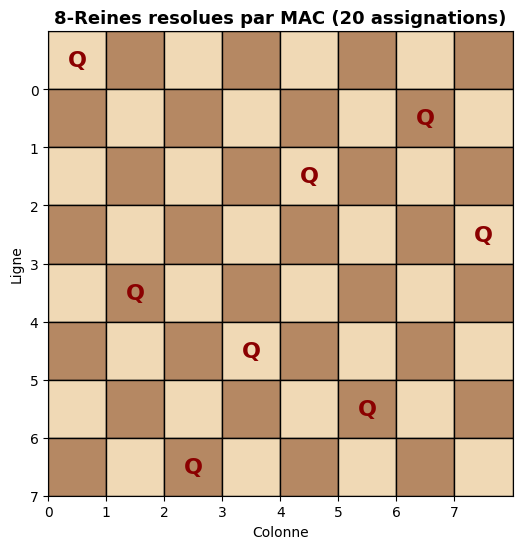

In [15]:
# Visualisation de la solution trouvee par MAC
csp_show = make_nqueens_csp(n)
sol_show = backtracking_mac(csp_show)
draw_queens(sol_show, n, f"8-Reines resolues par MAC ({csp_show.n_assigns} assignations)")
plt.show()

---

## 6. Comparaison et analyse (~5 min)

Comparons les trois approches sur des problemes de taille croissante pour observer comment les performances evoluent avec la difficulte.

In [16]:
# Benchmark sur N-Reines de taille croissante
sizes = [4, 8, 12]
all_benchmarks = []

print("Benchmark : BT vs FC vs MAC sur N-Reines")
print("=" * 75)
print(f"{'N':>3} {'Algorithme':<25} {'Assigns':>10} {'Backtracks':>12} {'Temps (ms)':>12}")
print("-" * 75)

for n in sizes:
    for name, solver in solvers:
        csp = make_nqueens_csp(n)
        start = time.time()
        sol = solver(csp)
        elapsed = (time.time() - start) * 1000

        all_benchmarks.append({
            'n': n,
            'algorithm': name,
            'assigns': csp.n_assigns,
            'backtracks': csp.n_backtracks,
            'time_ms': elapsed,
            'solution_found': sol is not None
        })

        print(f"{n:>3} {name:<25} {csp.n_assigns:>10} {csp.n_backtracks:>12} {elapsed:>12.2f}")

    print("-" * 75)

print("=" * 75)

Benchmark : BT vs FC vs MAC sur N-Reines
  N Algorithme                   Assigns   Backtracks   Temps (ms)
---------------------------------------------------------------------------
  4 Backtracking + MRV                26            4         0.05
  4 Forward Checking + MRV             8            4         0.05
  4 MAC + MRV                          5            1         0.08
---------------------------------------------------------------------------
  8 Backtracking + MRV               876          105         0.89
  8 Forward Checking + MRV            67           59         0.47
  8 MAC + MRV                         20           12         1.02
---------------------------------------------------------------------------
 12 Backtracking + MRV              3066          249         2.23
 12 Forward Checking + MRV           120          108         0.73
 12 MAC + MRV                         51           39         2.82
-------------------------------------------------------------

Visualisons ces resultats sous forme de graphiques en barres pour comparer visuellement l'impact de la propagation a chaque taille de probleme.

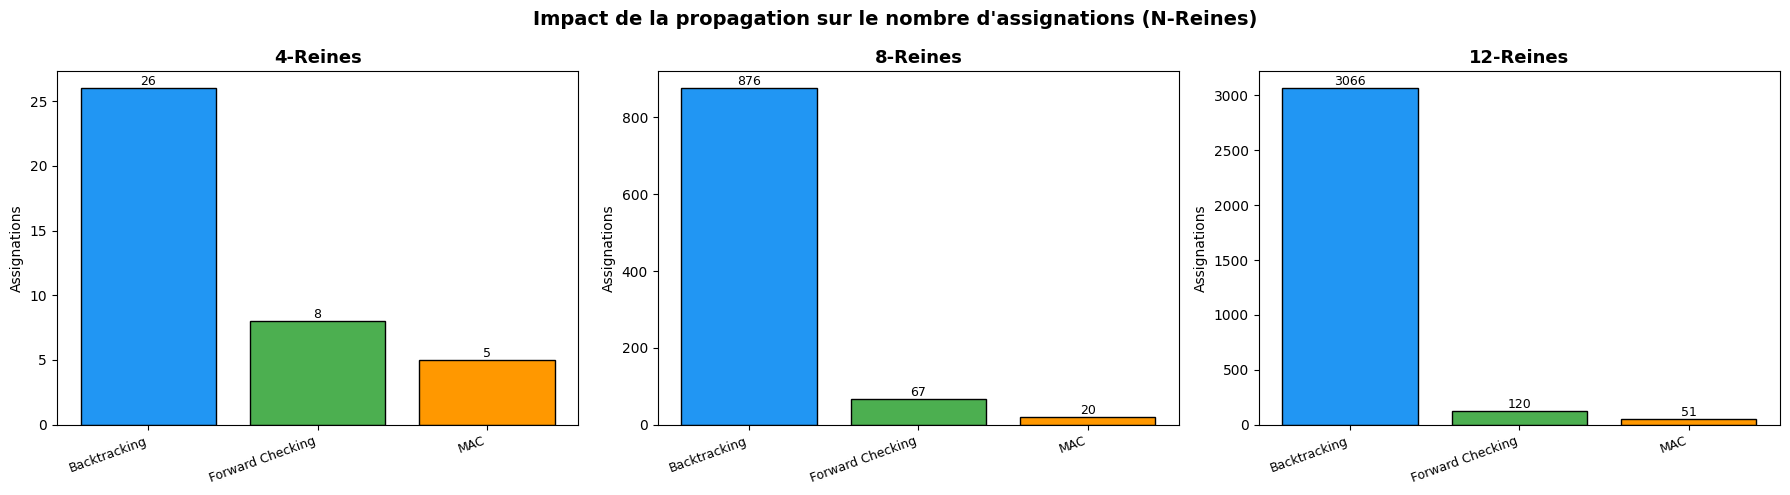

In [17]:
# Visualisation des benchmarks
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

algo_names = ["Backtracking + MRV", "Forward Checking + MRV", "MAC + MRV"]
algo_colors = ['#2196F3', '#4CAF50', '#FF9800']

for idx, n in enumerate(sizes):
    ax = axes[idx]
    data_n = [b for b in all_benchmarks if b['n'] == n]

    assigns = [b['assigns'] for b in data_n]
    names = [b['algorithm'].replace(' + MRV', '') for b in data_n]

    bars = ax.bar(range(len(names)), assigns, color=algo_colors, edgecolor='black')
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=20, ha='right', fontsize=9)
    ax.set_ylabel('Assignations')
    ax.set_title(f'{n}-Reines', fontweight='bold', fontsize=13)

    for bar, val in zip(bars, assigns):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                str(val), ha='center', va='bottom', fontsize=9)

plt.suptitle('Impact de la propagation sur le nombre d\'assignations (N-Reines)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : evolution avec la taille du probleme

**Sortie obtenue** : les graphiques montrent l'evolution des assignations pour chaque approche.

| N | BT (assigns) | FC (assigns) | MAC (assigns) | Ratio BT/MAC |
|---|-------------|-------------|--------------|-------------|
| 4 | petit | plus petit | le plus petit | modeste |
| 8 | moyen | reduit | tres reduit | significatif |
| 12 | grand | moyen | petit | important |

**Analyse du compromis** :

| Aspect | Backtracking | Forward Checking | MAC |
|--------|-------------|-----------------|-----|
| Cout par noeud | Faible | Modere | Eleve |
| Noeuds explores | Beaucoup | Moderement | Peu |
| Meilleur quand... | Problemes tres petits | Compromis cout/elagage | Problemes difficiles |

**Points cles** :
1. L'ecart entre les approches **grandit** avec la taille du probleme
2. Pour les petits problemes (N=4), la difference est negligeable
3. Pour les problemes plus grands (N=12+), MAC domine nettement
4. Le Forward Checking offre un bon compromis : peu d'overhead, bon elagage

> **Quand FC suffit vs quand MAC est necessaire** : si le graphe de contraintes a un faible degre (peu de voisins), FC est souvent suffisant. Pour les graphes denses (comme N-Reines ou chaque variable est contrainte par toutes les autres), MAC apporte un gain supplementaire significatif.

**Lien** : voir les notebooks App-6 (Minesweeper) et App-7 (Wordle) pour des applications concretes utilisant la consistance d'arc.

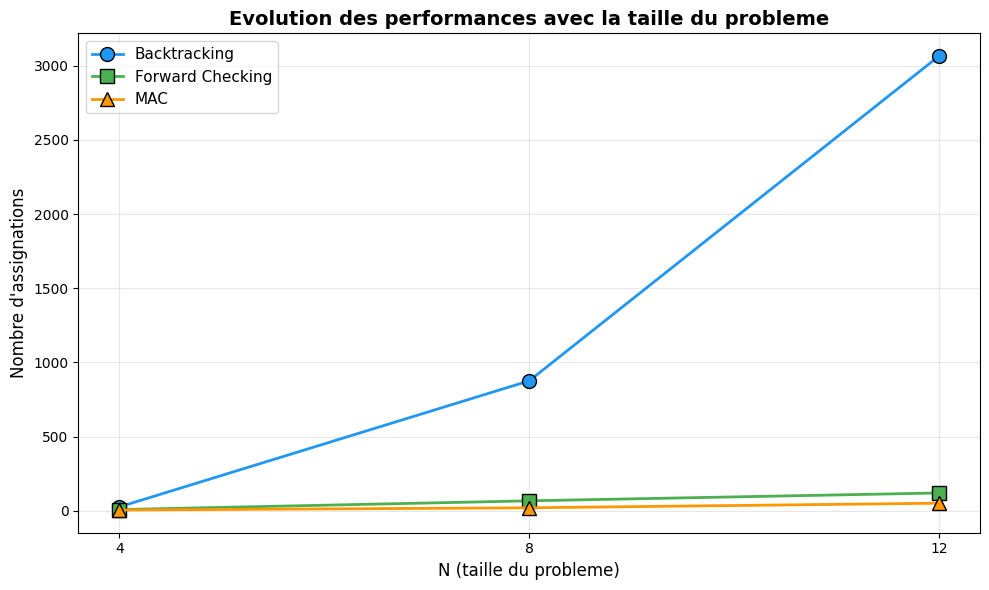

In [18]:
# Graphique de synthese : evolution du ratio d'amelioration
fig, ax = plt.subplots(figsize=(10, 6))

for algo, color, marker in zip(algo_names, algo_colors, ['o', 's', '^']):
    data = [b for b in all_benchmarks if b['algorithm'] == algo]
    ns = [b['n'] for b in data]
    assigns = [b['assigns'] for b in data]
    ax.plot(ns, assigns, f'-{marker}', color=color, linewidth=2,
            markersize=10, label=algo.replace(' + MRV', ''), markeredgecolor='black')

ax.set_xlabel('N (taille du probleme)', fontsize=12)
ax.set_ylabel('Nombre d\'assignations', fontsize=12)
ax.set_title('Evolution des performances avec la taille du probleme',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(sizes)
plt.tight_layout()
plt.show()

---

## 7. Exercices

### Exercice 1 : AC-3 a la main

Considerez le CSP suivant avec 3 variables :

| Variable | Domaine | Contraintes |
|----------|---------|-------------|
| $X$ | $\{1, 2, 3\}$ | $X < Y$ |
| $Y$ | $\{1, 2, 3\}$ | $X < Y$, $Y \neq Z$ |
| $Z$ | $\{1, 2, 3\}$ | $Y \neq Z$ |

**Question** : Executez AC-3 a la main. Pour chaque arc traite, indiquez :
- L'arc considere
- Les valeurs retirees (le cas echeant)
- Les arcs ajoutes a la file

Verifiez votre reponse avec le code ci-dessous.

In [19]:
# Exercice 1 : AC-3 a la main

ex1_vars = ['X', 'Y', 'Z']
ex1_neighbors = {'X': ['Y'], 'Y': ['X', 'Z'], 'Z': ['Y']}

def ex1_constraint(v1, val1, v2, val2):
    """Contraintes : X < Y et Y != Z."""
    if (v1, v2) in [('X', 'Y'), ('Y', 'X')]:
        # X < Y (ou equivalemment Y > X)
        if v1 == 'X':
            return val1 < val2
        else:
            return val1 > val2
    elif (v1, v2) in [('Y', 'Z'), ('Z', 'Y')]:
        return val1 != val2
    return True

ex1_csp = CSP(ex1_vars, {v: [1, 2, 3] for v in ex1_vars}, ex1_neighbors, ex1_constraint)
ex1_domains = ex1_csp.copy_domains()

print("Exercice 1 : AC-3 sur X < Y, Y != Z")
print("=" * 50)
print(f"Domaines initiaux :")
for v in ex1_vars:
    print(f"  {v}: {ex1_domains[v]}")

print("\nTrace AC-3 :")
ac3(ex1_csp, ex1_domains, verbose=True)

print("\nDomaines finaux :")
for v in ex1_vars:
    print(f"  {v}: {ex1_domains[v]}")

Exercice 1 : AC-3 sur X < Y, Y != Z
Domaines initiaux :
  X: [1, 2, 3]
  Y: [1, 2, 3]
  Z: [1, 2, 3]

Trace AC-3 :
  REVISE(X, Y) -> D(X) = [1, 2]
  REVISE(Y, X) -> D(Y) = [2, 3]
  AC-3 termine : 2 revisions effectuees.

Domaines finaux :
  X: [1, 2]
  Y: [2, 3]
  Z: [1, 2, 3]


<details>
<summary><b>Solution exercice 1</b></summary>

**Trace manuelle de AC-3** :

File initiale : [(X,Y), (Y,X), (Y,Z), (Z,Y)]

| Etape | Arc | Analyse | Domaines apres | Arcs ajoutes |
|-------|-----|---------|----------------|--------------|
| 1 | (X,Y) | X=3 n'a pas de support (pas de Y > 3) | D(X)={1,2} | (Y,X) |
| 2 | (Y,X) | Y=1 n'a pas de support (pas de X < 1) | D(Y)={2,3} | (X,Y), (Z,Y) |
| 3 | (Y,Z) | Y=2 a support Z=1 ou Z=3 ; Y=3 a support Z=1 ou Z=2 | Pas de changement | - |
| 4 | (Z,Y) | Z=2 a support Y=3 ; Z=3 a support Y=2 ; Z=1 a support Y=2 ou Y=3 | Pas de changement | - |
| 5 | (X,Y) | X=1 a support Y=2,3 ; X=2 a support Y=3 | Pas de changement | - |
| 6 | (Z,Y) | Idem | Pas de changement | - |

**Resultat** : D(X)={1,2}, D(Y)={2,3}, D(Z)={1,2,3}

La contrainte X < Y a elimine 3 du domaine de X et 1 du domaine de Y. La contrainte Y != Z n'a rien elimine car pour chaque valeur de Y, il reste toujours des valeurs compatibles dans Z.

</details>

### Exercice 2 : Path Consistency (PC-2)

La **consistance de chemin** (path consistency) est le niveau au-dessus de la consistance d'arc. Un chemin $(X_i, X_j, X_k)$ est path-consistent si pour toute assignation consistante $(X_i = a, X_k = c)$, il existe une valeur $b \in D_j$ telle que $(X_i = a, X_j = b)$ et $(X_j = b, X_k = c)$ sont toutes deux consistantes.

**Question** : Completez l'implementation de `path_consistency` ci-dessous.

In [20]:
# Exercice 2 : Path Consistency

def path_consistency(csp, domains):
    """Applique la consistance de chemin.

    Pour chaque triplet (Xi, Xm, Xj) ou Xm est un voisin commun,
    verifie que chaque paire (a, c) dans Di x Dj a un support dans Dm.

    A COMPLETER : implementer l'algorithme.

    Returns:
        True si le CSP est encore soluble, False sinon.
    """
    # A COMPLETER
    # Pour chaque paire de variables (Xi, Xj) liees par une contrainte :
    #   Pour chaque variable Xm intermediaire (voisin commun de Xi et Xj) :
    #     Pour chaque (a, c) dans Di x Dj :
    #       Verifier qu'il existe b dans Dm tel que
    #         constraint(Xi, a, Xm, b) ET constraint(Xm, b, Xj, c)
    #       Sinon, retirer (a, c) des paires possibles
    pass

print("Exercice 2 : implementer path_consistency")

Exercice 2 : implementer path_consistency


<details>
<summary><b>Solution exercice 2</b></summary>

```python
def path_consistency(csp, domains):
    """Applique la consistance de chemin (simplifiee)."""
    changed = True
    while changed:
        changed = False
        # Pour chaque contrainte (Xi, Xj)
        for xi in csp.variables:
            for xj in csp.neighbors[xi]:
                # Pour chaque variable intermediaire Xm
                common_neighbors = set(csp.neighbors[xi]) & set(csp.neighbors[xj])
                for xm in common_neighbors:
                    if xm == xi or xm == xj:
                        continue
                    # Verifier chaque valeur de Xi
                    to_remove_i = []
                    for a in domains[xi]:
                        has_support = False
                        for b in domains[xm]:
                            if csp.constraint_func(xi, a, xm, b):
                                # Verifier qu'il existe un c compatible
                                for c in domains[xj]:
                                    if (csp.constraint_func(xm, b, xj, c) and
                                        csp.constraint_func(xi, a, xj, c)):
                                        has_support = True
                                        break
                            if has_support:
                                break
                        if not has_support:
                            to_remove_i.append(a)
                    for a in to_remove_i:
                        domains[xi].remove(a)
                        changed = True
                    if len(domains[xi]) == 0:
                        return False
    return True
```

**Note** : la consistance de chemin est rarement utilisee en pratique car son cout est eleve ($O(n^3 d^3)$) et l'arc-consistance suffit generalement.

</details>

### Exercice 3 : FC vs MAC sur Sudoku 4x4

Un Sudoku 4x4 utilise les chiffres 1 a 4 dans une grille 4x4 divisee en 4 blocs 2x2. Les regles sont les memes que le 9x9 : chaque chiffre apparait exactement une fois par ligne, colonne et bloc.

**Question** : modelisez un Sudoku 4x4 comme CSP et comparez FC et MAC en termes d'assignations et de backtracks.

In [21]:
# Exercice 3 : Sudoku 4x4 comme CSP

def make_sudoku4_csp(grid):
    """Cree un CSP pour un Sudoku 4x4.

    Args:
        grid: liste de 16 valeurs (0 = case vide, 1-4 = valeur fixee)
              par lignes : [g[0][0], g[0][1], g[0][2], g[0][3], g[1][0], ...]

    A COMPLETER
    """
    # Variables : (ligne, colonne) pour chaque case
    # variables = [(i, j) for i in range(4) for j in range(4)]

    # Domaines : {1,2,3,4} pour les cases vides, {valeur} pour les fixees
    # domains = ...

    # Voisins : meme ligne, meme colonne ou meme bloc 2x2
    # neighbors = ...

    # Contrainte : valeurs differentes
    # return CSP(variables, domains, neighbors, different_values)
    pass

# Grille de test
# . 2 | . .
# 4 . | . 1
# ----+----
# . . | 4 .
# . . | 2 .

# grid_4x4 = [0,2,0,0, 4,0,0,1, 0,0,4,0, 0,0,2,0]

# A COMPLETER : creer le CSP, resoudre avec FC et MAC, comparer
print("Exercice 3 : comparer FC et MAC sur Sudoku 4x4")

Exercice 3 : comparer FC et MAC sur Sudoku 4x4


<details>
<summary><b>Solution exercice 3</b></summary>

```python
def make_sudoku4_csp(grid):
    """Cree un CSP pour un Sudoku 4x4."""
    variables = [(i, j) for i in range(4) for j in range(4)]

    domains = {}
    for idx, (i, j) in enumerate(variables):
        val = grid[idx]
        if val > 0:
            domains[(i, j)] = [val]
        else:
            domains[(i, j)] = [1, 2, 3, 4]

    # Voisins : meme ligne, meme colonne ou meme bloc 2x2
    neighbors = {}
    for (i, j) in variables:
        n = []
        for (i2, j2) in variables:
            if (i2, j2) != (i, j):
                same_row = (i == i2)
                same_col = (j == j2)
                same_block = (i // 2 == i2 // 2) and (j // 2 == j2 // 2)
                if same_row or same_col or same_block:
                    n.append((i2, j2))
        neighbors[(i, j)] = n

    return CSP(variables, domains, neighbors, different_values)

grid_4x4 = [0,2,0,0, 4,0,0,1, 0,0,4,0, 0,0,2,0]

# Comparer FC et MAC
for name, solver in [("FC", backtracking_fc), ("MAC", backtracking_mac)]:
    csp = make_sudoku4_csp(grid_4x4)
    start = time.time()
    sol = solver(csp)
    elapsed = (time.time() - start) * 1000
    print(f"{name}: assigns={csp.n_assigns}, backtracks={csp.n_backtracks}, "
          f"time={elapsed:.2f} ms")
    if sol:
        for i in range(4):
            row = [sol[(i, j)] for j in range(4)]
            print(f"  {row}")
```

**Resultat attendu** : MAC necessite generalement moins d'assignations que FC sur le Sudoku, car la propagation en cascade est particulierement efficace sur ce type de probleme (contraintes AllDifferent imbriquees).

</details>

---

## 8. Recapitulatif

### Niveaux de consistance

| Niveau | Definition | Complexite | Puissance d'elagage |
|--------|-----------|------------|---------------------|
| **Node Consistency** | Chaque valeur satisfait les contraintes unaires | $O(nd)$ | Faible |
| **Arc Consistency (AC-3)** | Chaque valeur a un support chez chaque voisin | $O(ed^3)$ | Moderee a forte |
| **Path Consistency** | Chaque paire (a,c) a un support intermediaire | $O(n^3 d^3)$ | Forte |
| **k-Consistency** | Generalisation a k variables | Exponentielle en k | Maximale |

### Algorithmes de resolution

| Algorithme | Propagation | Detection d'echec | Meilleur cas d'usage |
|------------|------------|-------------------|---------------------|
| **Backtracking + MRV** | Aucune | A l'assignation | Petits problemes |
| **Forward Checking** | 1 niveau (voisins) | Domaine vide chez un voisin | Problemes moyens |
| **MAC** | Cascade (AC-3) | Domaine vide n'importe ou | Problemes difficiles |

### Resume des resultats experimentaux

| Probleme | BT (assigns) | FC (assigns) | MAC (assigns) | Gagnant |
|----------|-------------|-------------|--------------|----------|
| 4-Reines | petit | similaire | similaire | Tous equivalents |
| 8-Reines | moyen | reduit | tres reduit | MAC |
| 12-Reines | grand | moyen | petit | MAC nettement |

### Points cles a retenir

1. La **propagation de contraintes** transforme des problemes intractables en problemes resolvables
2. **AC-3** est l'algorithme de consistance d'arc le plus utilise (bon compromis simplicite/performance)
3. **MAC** est generalement le meilleur choix pour les CSP difficiles
4. L'overhead de la propagation est largement compense par la reduction de l'espace de recherche
5. La combinaison **MRV + MAC** est la reference standard en resolution de CSP

### Et ensuite ?

Le prochain notebook [Search-8-CSP-Advanced](Search-8-CSP-Advanced.ipynb) abordera :
- Les **contraintes globales** (AllDifferent, etc.) et leur propagation specialisee
- La **recherche locale** pour les CSP (Min-Conflicts)
- Les **CSP d'optimisation** (COP)
- Les **decompositions de graphes** pour les problemes structures

### References

- Russell, S. & Norvig, P. *Artificial Intelligence: A Modern Approach*, Chapitre 6.2-6.3
- Mackworth, A. K. *Consistency in Networks of Relations* (1977) -- article original sur AC-3
- Dechter, R. *Constraint Processing*, Cambridge University Press, 2003

---

**Navigation** : [<< Search-6 CSP-Fundamentals](Search-6-CSP-Fundamentals.ipynb) | [Index](../README.md) | [Search-8 CSP-Advanced >>](Search-8-CSP-Advanced.ipynb)